[![](https://img.youtube.com/vi/FnV0thLS1Fs/0.jpg)](https://www.youtube.com/watch?v=FnV0thLS1Fs)

pixyz  
last update 2022 02 26  
ゆっくりしていってね！  

**霊夢：今回は回帰タスクのコンペかな？  
魔理沙：まずは概要を読んでみよう。**

**Reimu: Is this a regression task competition?  
Marisa: First, let's read the overview.**

別の年、動揺を予測し、確率を呼び出し、ブラケット学のスキルをリーダーボードテストにかける別のチャンス。3月に開催される第8回機械学習マニア大会では、カグラーズが今年の米国男子大学バスケットボールトーナメントの結果を予測しようとする何百万人ものファンに再び参加します。しかし、ほとんどのファンとは異なり、豊富な履歴データと計算能力の組み合わせを使用して勝者と敗者を選び、テレビでグラウンドトゥルースが展開されます。

過去のNCAAゲームのデータが提供されており、他の公開されているデータソースを使用して勝利を収めることをお勧めします。

この2段階のコンテストの第1段階では、参加者は以前のトーナメントに対してモデルを作成してテストします。第2段階では、参加者は2022年のトーナメントの結果を予測します。2番目のステージに入るのに最初のステージに参加する必要はありません。最初の段階は、モデル構築を奨励し、予測をスコアリングする手段を提供するために存在します。実際の競争は2022年の結果を予測しています。

そして、米国の女子大学バスケットボールトーナメントの結果を予測するために見られる私たちのコンパニオンコンペティションを見るのを忘れないでください！

Another year, another chance to predict the upsets, call the probabilities, and put your bracketology skills to the leaderboard test. In our eighth annual March Machine Learning Mania competition, Kagglers will once again join the millions of fans who attempt to predict the outcomes of this year's US men's college basketball tournament. But unlike most fans, you will pick the winners and losers using a combination of rich historical data and computing power, while the ground truth unfolds on television.

You're provided data of historical NCAA games and are encouraged to use other sources of publicly available data to gain a winning edge.

In stage one of this two-stage competition, participants will build and test their models against previous tournaments. In the second stage, participants will predict the outcome of the 2022 tournament. You don’t need to participate in the first stage to enter the second. The first stage exists to incentivize model building and provide a means to score predictions. The real competition is forecasting the 2022 results.

And don't forget to take a look at our companion competition that looks to predict the outcome of the US women's college basketball tournament!

<img src = "https://storage.googleapis.com/kaggle-competitions/kaggle/4862/media/bball-logo.png" width = 700>

**魔理沙:今回はlightgbmを使ったbaselineを作っていくよ。  
霊夢：今回はデータの種類がとても多いね。あれ？trainデータはどこ？  
魔理沙:trainデータは自分でいくつかのデータを組み合わせて作るしかないみたいだな。これは骨が折れそうだ。**

**Marisa: This time I'm going to make a baseline using lightgbm.  
Reimu: There are so many types of data this time. that? Where is the train data?  
Marisa: It seems that train data can only be created by combining some data. This is going to be a pain.**

<img src = "https://4.bp.blogspot.com/-uoVuBWIbdiA/WvQHqpx_YCI/AAAAAAABL8g/NiFZ6K71VBc_0_dcKb3_4nhnvFJ_JMNuACLcBGAs/s450/network_dennou_sekai_figure.png" width = 200>

# Import

In [1]:
import pandas as pd
import os.path as osp
import numpy as np
import random
import time
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
DATA_PATH = 'data/MDataFiles_Stage1/'

# Config

In [3]:
class config:    
    
    SEED = 42
    FOLD_TO_RUN = 0
    FOLDS = 5
    EARLY_STOPPING_ROUNDS = 200
    VERBOSE = 1000
    
    model_type = 'lgb_regression'  
    EPOCHS = 20000
    LR = 2e-4
    message='baseline'
    TARGET = 'target'
    
    TEST = False

In [4]:
if config.TEST:
    config.EPOCHS = 100

**魔理沙:今回はFOLD5、EPOCH20000で学習をしていくぜ**  

**Marisa: This time, I'll study with FOLD5 and EPOCH20000**

# Data

**魔理沙:データは以下の通りだぜ。**  

**Marisa: The data is as follows.**

In [5]:
!ls /workspace/data/MDataFiles_Stage1

Cities.csv			 MRegularSeasonCompactResults.csv
Conferences.csv			 MRegularSeasonDetailedResults.csv
MConferenceTourneyGames.csv	 MSampleSubmissionStage1.csv
MGameCities.csv			 MSeasons.csv
MMasseyOrdinals.csv		 MSecondaryTourneyCompactResults.csv
MNCAATourneyCompactResults.csv	 MSecondaryTourneyTeams.csv
MNCAATourneyDetailedResults.csv  MTeamCoaches.csv
MNCAATourneySeedRoundSlots.csv	 MTeamConferences.csv
MNCAATourneySeeds.csv		 MTeamSpellings.csv
MNCAATourneySlots.csv		 MTeams.csv


**霊夢:一番大事なデータはどれだろう？  
魔理沙:まずはMNCAATourneyDetailedResultsかな。これを主軸にやっていくぜ。**

**Reimu: Which is the most important data?  
Marisa: First of all, MNCAA Tourney Detailed Results. Let's do this as the main axis.**

In [6]:
df_TDresults = pd.read_csv(DATA_PATH + "MNCAATourneyDetailedResults.csv")
df_RSDresults = pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv")
df_TDresults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


**霊夢:このままだとデータ量が少ないね。  
魔理沙:そうだね、だからMRegularSeasonDetailedResultsも追加して量を増やそう。  
霊夢:これでうまくいくといいな―**

**Reimu: The amount of data is small at this rate.  
Marisa: That's right, so let's add MRegularSeasonDetailedResults to increase the amount.  
Reimu: Hope this works**

<img src="https://1.bp.blogspot.com/-5i9P5bsm_CA/Xbo6PsHbZ-I/AAAAAAABVvg/5uwfw-rUEt4VeLDEbS4YUIViH3SkealiACNcBGAsYHQ/s400/yaruki_aru_casual_woman.png" width = 200>

In [7]:
df_TDresults = pd.merge(df_RSDresults,df_TDresults,on = df_TDresults.columns.tolist(),how = "outer")
len(df_TDresults)

101604

**霊夢:FGMとかFGAって何のこと？  
魔理沙:バスケには詳しくないから具体的には分からないが、どうやらどれもゲーム内で起こした特定のアクションの数みたいだね。  
霊夢:試合ごとにばらばらだからどうやって扱おうかな？  
魔理沙:とりあえずSeason、TeamIDごとに平均をとって特徴量にしよう。上手くいくかはちょっとわからないかな。**

**Reimu: What is FGM or FGA?  
Marisa: I'm not familiar with basketball, so I don't know the specifics, but it seems that all of them seem to be the number of specific actions taken in the game.  
Reimu: How do you handle it because it's different for each match?  
Marisa: For the time being, let's take the average for each Season and Team ID and use it as a feature. I don't know if it will work.**

<img src="http://3.bp.blogspot.com/-KmQQLtEkmLw/U1T3r7D0NdI/AAAAAAAAfVI/c2d4n2kG00U/s400/figure_question.png" width="200">

In [8]:
box_col = ["FGM","FGA","FGM3","FTM","FTA","OR","DR","Ast","TO","Stl","Blk","PF"]
df_boxW = df_TDresults[["Season","WTeamID"]+["W" + col for col in box_col]]
df_boxL = df_TDresults[["Season","LTeamID"]+["L" + col for col in box_col]]
df_boxW = df_boxW.rename(columns={"WTeamID":"TeamID"})
df_boxW = df_boxW.rename(columns={("W"+ col):col for col in box_col})
df_boxL = df_boxL.rename(columns={"LTeamID":"TeamID"})
df_boxL = df_boxL.rename(columns={("L"+ col):col for col in box_col})
df_box = pd.merge(df_boxW,df_boxL,on = ["Season","TeamID"]+box_col,how="outer")
df_box = df_box.groupby(["Season","TeamID"])[box_col].agg(np.mean).reset_index()
df_box.head()

,Season,TeamID,FGM,FGA,FGM3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,19.142857,39.785714,7.821429,11.142857,17.107143,4.178571,16.821429,13.000000,11.428571,5.964286,1.785714,18.750000
1,2003,1103,27.148148,55.851852,5.444444,19.037037,25.851852,9.777778,19.925926,15.222222,12.629630,7.259259,2.333333,19.851852
2,2003,1104,23.965517,57.000000,6.310345,14.793103,20.758621,13.413793,23.793103,12.137931,13.103448,6.448276,3.862069,18.137931
3,2003,1105,24.384615,61.615385,7.576923,15.423077,21.846154,13.500000,23.115385,14.538462,18.653846,9.307692,2.076923,20.230769
4,2003,1106,23.428571,55.285714,6.107143,10.642857,16.464286,12.285714,23.857143,11.678571,17.035714,8.357143,3.142857,18.178571


**霊夢:そういえばこのままだと絶対左側のチームIDが勝つことになっちゃうじゃん！<br>
魔理沙:そうだった。TeamIDなどのデータを勝ったチームと負けたチームを反転させたデータを下にくっつけよう。これでデータ量も2倍になるぞ。**

**Reimu: By the way, the team ID on the left side will definitely win! <br>
Marisa: That's right. Let's attach the data such as Team ID, which is the reverse of the winning team and the losing team, to the bottom. This will double the amount of data.**

<img src="https://4.bp.blogspot.com/-WOvX4GkiSEo/U1T3wVr3ovI/AAAAAAAAfWg/RpbQYAHDo2Y/s400/figure_shock.png" width = 200>

In [9]:
df_TDresults2 = df_TDresults
df_TDresults = df_TDresults.rename(columns={"WTeamID":"Team1ID","LTeamID":"Team2ID","WScore":"T1Score","LScore":"T2Score"})
df_TDresults = df_TDresults.rename(columns={f"W{col}":f"T1{col}" for col in box_col})
df_TDresults = df_TDresults.rename(columns={f"L{col}":f"T2{col}" for col in box_col})
df_TDresults2 = df_TDresults2.rename(columns={"WTeamID":"Team2ID","LTeamID":"Team1ID","WScore":"T2Score","LScore":"T1Score"})

**霊夢:targetはどうするの？  
魔理沙:Team1が勝ったときは1.0、負けたときは0.0にしよう。**

**Reimu: What about target?  
Marisa: Let's set it to 1.0 when Team 1 wins and 0.0 when it loses.**

In [10]:
features = ["Season","Team1ID","Team2ID","T1Score","T2Score",'target']
df_TDresults['target'] = 1.0
df_TDresults2['target'] = 0.0
train = pd.merge(df_TDresults,df_TDresults2,on = features,how="outer")
train = train[features]
train.head()

,Season,Team1ID,Team2ID,T1Score,T2Score,target
0,2003,1104,1328,68,62,1.0
1,2003,1272,1393,70,63,1.0
2,2003,1266,1437,73,61,1.0
3,2003,1296,1457,56,50,1.0
4,2003,1400,1208,77,71,1.0


In [11]:
box_T1 = df_box.copy()
box_T2 = df_box.copy()
box_T1.columns = ['Season','Team1ID'] + ["T1"+col+"_mean" for col in box_col]
box_T2.columns = ['Season','Team2ID'] + ["T2"+col+"_mean" for col in box_col]
train = pd.merge(train,box_T1,on = ["Season","Team1ID"],how = "left")
train = pd.merge(train,box_T2,on = ["Season","Team2ID"],how = "left")

**霊夢:今度は何をするの？  
魔理沙:次はseedを特徴量として組み込もう！**

**Reimu: What are you going to do next time?  
Marisa: Next, let's incorporate seed as a feature!**

<img src = "https://1.bp.blogspot.com/-FrFmmMlJ0bE/U1T3wsYJlRI/AAAAAAAAfWo/7-7pGdnlkKQ/s400/figure_talking.png" width = 200>

In [12]:
df_seeds = pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv")
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


**霊夢:それぞれのチームのseedが独立した特徴量で正しく学習できるのかな？  
魔理沙:ちょっと心配だね。seedの差を取った特徴量も作っておこう**

**Reimu: Can the seeds of each team learn correctly with independent features?  
Marisa: I'm a little worried. Let's make a feature quantity with the difference in seed**

In [13]:
df_seeds["seed"] = df_seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds_T1 = df_seeds[['Season','TeamID','seed']].copy()
seeds_T2 = df_seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','Team1ID','T1_seed']
seeds_T2.columns = ['Season','Team2ID','T2_seed']
train = pd.merge(train,seeds_T1,on = ["Season","Team1ID"],how = "left")
train = pd.merge(train,seeds_T2,on = ["Season","Team2ID"],how = "left")
train["seeddiff"] = train["T1_seed"] - train["T2_seed"]

**霊夢:次はどうするの？  
魔理沙:次はランキングを特徴量にするよ。  
霊夢:でもランキングはいろいろ種類があるみたいだけどどうする？  
魔理沙：そうだなー、とりあえず平均をとるか。**

**Reimu: What's next?  
Marisa: Next, let's make the ranking a feature.  
Reimu: But there seem to be various rankings, but what do you do?  
Marisa: That's right, do you take the average for the time being?**

<img src="https://2.bp.blogspot.com/-nMjuko9tXGc/Ut0BV0jJHkI/AAAAAAAAdW0/tRb8t3PEY28/s400/kangaeruhito.png" width = 200>

In [14]:
df_MMOrdinals = pd.read_csv(DATA_PATH + "MMasseyOrdinals.csv")
df_rank = df_MMOrdinals.groupby(["Season","TeamID"])["OrdinalRank"].agg(np.mean).reset_index()
df_rank.head()

,Season,TeamID,OrdinalRank
0,2003,1102,144.287500
1,2003,1103,182.205000
2,2003,1104,27.655502
3,2003,1105,305.377500
4,2003,1106,243.265000


**魔理沙:こっちもseedと同様に差を取っておこう。**

**Marisa: Let's make a difference here as well as seed.**

In [15]:
ranks_T1 = df_rank.copy()
ranks_T2 = df_rank.copy()
ranks_T1.columns = ['Season','Team1ID','T1_rank_mean']
ranks_T2.columns = ['Season','Team2ID','T2_rank_mean']
train = pd.merge(train,ranks_T1,on = ["Season","Team1ID"],how = "left")
train = pd.merge(train,ranks_T2,on = ["Season","Team2ID"],how = "left")
train["rankdiff"] = train["T1_rank_mean"] - train["T2_rank_mean"]

In [16]:
features = train.drop(columns = ["target","T1Score","T2Score"]).columns
train.head()

,Season,Team1ID,Team2ID,T1Score,T2Score,target,T1FGM_mean,T1FGA_mean,T1FGM3_mean,T1FTM_mean,...,T2TO_mean,T2Stl_mean,T2Blk_mean,T2PF_mean,T1_seed,T2_seed,seeddiff,T1_rank_mean,T2_rank_mean,rankdiff
0,2003,1104,1328,68,62,1.0,23.965517,57.000000,6.310345,14.793103,...,12.117647,6.970588,3.617647,18.205882,10.0,1.0,9.0,27.655502,15.730233,11.925270
1,2003,1272,1393,70,63,1.0,26.233333,60.300000,7.000000,14.933333,...,14.114286,8.514286,7.057143,16.857143,7.0,3.0,4.0,42.000000,25.596154,16.403846
2,2003,1266,1437,73,61,1.0,27.303030,56.696970,6.121212,17.727273,...,16.033333,7.500000,3.400000,20.900000,3.0,NaN,NaN,18.967442,60.385000,-41.417558
3,2003,1296,1457,56,50,1.0,24.354839,53.064516,6.290323,14.612903,...,14.642857,7.607143,5.392857,19.642857,NaN,NaN,NaN,147.512500,209.452500,-61.940000
4,2003,1400,1208,77,71,1.0,27.757576,62.272727,5.939394,17.878788,...,11.555556,7.629630,4.370370,17.185185,1.0,NaN,NaN,9.416279,19.261283,-9.845004


**霊夢:これで一通りのデータができあがったね。  
魔理沙：でもまだ終わりじゃないよ、testデータも同様にして作っていこう。  
霊夢：ああ大変だあ**

**Reimu: That's all the data.  
Marisa: But it's not over yet, let's make test data in the same way.  
Reimu: Oh, it's hard**

<img src="https://3.bp.blogspot.com/-3q31Kj8zFHc/V6BP6vEGe1I/AAAAAAAA83s/YD0NZlG5wmgMiB_iX9QMDy8KF2IEid6qQCLcB/s450/figure_korobu.png" width="200">

In [17]:
test = pd.read_csv(DATA_PATH + "MSampleSubmissionStage1.csv")
test.head()

,ID,Pred
0,2016_1112_1114,0.5
1,2016_1112_1122,0.5
2,2016_1112_1124,0.5
3,2016_1112_1138,0.5
4,2016_1112_1139,0.5


In [18]:
test["Season"] = test['ID'].apply(lambda x: int(x[0:4]))
test["Team1ID"] = test['ID'].apply(lambda x: int(x[5:9]))
test["Team2ID"] = test['ID'].apply(lambda x: int(x[10:14]))
test.head()

,ID,Pred,Season,Team1ID,Team2ID
0,2016_1112_1114,0.5,2016,1112,1114
1,2016_1112_1122,0.5,2016,1112,1122
2,2016_1112_1124,0.5,2016,1112,1124
3,2016_1112_1138,0.5,2016,1112,1138
4,2016_1112_1139,0.5,2016,1112,1139


In [19]:
test = pd.merge(test,box_T1,on = ["Season","Team1ID"],how = "left")
test = pd.merge(test,box_T2,on = ["Season","Team2ID"],how = "left")
test.head()

,ID,Pred,Season,Team1ID,Team2ID,T1FGM_mean,T1FGA_mean,T1FGM3_mean,T1FTM_mean,T1FTA_mean,...,T2FGM3_mean,T2FTM_mean,T2FTA_mean,T2OR_mean,T2DR_mean,T2Ast_mean,T2TO_mean,T2Stl_mean,T2Blk_mean,T2PF_mean
0,2016_1112_1114,0.5,2016,1112,1114,27.823529,57.941176,6.5,18.294118,25.382353,...,7.424242,12.696970,17.424242,8.848485,24.393939,12.666667,10.121212,6.333333,2.909091,18.242424
1,2016_1112_1122,0.5,2016,1112,1122,27.823529,57.941176,6.5,18.294118,25.382353,...,6.147059,17.588235,26.235294,11.205882,24.705882,12.676471,14.470588,6.941176,2.676471,17.794118
2,2016_1112_1124,0.5,2016,1112,1124,27.823529,57.941176,6.5,18.294118,25.382353,...,6.181818,16.272727,22.454545,13.575758,23.060606,17.060606,12.636364,7.757576,3.909091,19.545455
3,2016_1112_1138,0.5,2016,1112,1138,27.823529,57.941176,6.5,18.294118,25.382353,...,7.441176,17.558824,24.735294,11.970588,26.617647,12.411765,13.705882,6.647059,3.411765,21.411765
4,2016_1112_1139,0.5,2016,1112,1139,27.823529,57.941176,6.5,18.294118,25.382353,...,7.151515,17.151515,23.454545,11.090909,24.818182,14.181818,10.151515,6.878788,3.242424,19.636364


In [20]:
test = pd.merge(test,seeds_T1,on = ["Season","Team1ID"],how = "left")
test = pd.merge(test,seeds_T2,on = ["Season","Team2ID"],how = "left")
test["seeddiff"] = test["T1_seed"] - test["T2_seed"]

In [21]:
test = pd.merge(test,ranks_T1,on = ["Season","Team1ID"],how = "left")
test = pd.merge(test,ranks_T2,on = ["Season","Team2ID"],how = "left")
test["rankdiff"] = test["T1_rank_mean"] - test["T2_rank_mean"]

In [22]:
test = test.drop(columns = ['ID','Pred'])
test.head()

,Season,Team1ID,Team2ID,T1FGM_mean,T1FGA_mean,T1FGM3_mean,T1FTM_mean,T1FTA_mean,T1OR_mean,T1DR_mean,...,T2TO_mean,T2Stl_mean,T2Blk_mean,T2PF_mean,T1_seed,T2_seed,seeddiff,T1_rank_mean,T2_rank_mean,rankdiff
0,2016,1112,1114,27.823529,57.941176,6.5,18.294118,25.382353,11.588235,28.617647,...,10.121212,6.333333,2.909091,18.242424,6,12,-6,17.185969,65.236495,-48.050526
1,2016,1112,1122,27.823529,57.941176,6.5,18.294118,25.382353,11.588235,28.617647,...,14.470588,6.941176,2.676471,17.794118,6,16,-10,17.185969,240.804612,-223.618643
2,2016,1112,1124,27.823529,57.941176,6.5,18.294118,25.382353,11.588235,28.617647,...,12.636364,7.757576,3.909091,19.545455,6,5,1,17.185969,29.179054,-11.993085
3,2016,1112,1138,27.823529,57.941176,6.5,18.294118,25.382353,11.588235,28.617647,...,13.705882,6.647059,3.411765,21.411765,6,14,-8,17.185969,143.247573,-126.061604
4,2016,1112,1139,27.823529,57.941176,6.5,18.294118,25.382353,11.588235,28.617647,...,10.151515,6.878788,3.242424,19.636364,6,9,-3,17.185969,30.925926,-13.739957


# Model&Train

**霊夢:やっと学習だ！<br>
魔理沙:上手くいくかなあ**

**Reimu: It's finally learning!<br>
Marisa: I wonder if it will work**

<img src="https://1.bp.blogspot.com/-flCQBhvvg6U/V6BP7KK5RdI/AAAAAAAA830/exz5qqb8M0U-hyss5tb4p6St5nF9aq0-wCLcB/s800/figure_ouen.png" width = 200>

In [23]:
lgb_params = {
    'objective': 'regression',
    'n_estimators': config.EPOCHS,
    'random_state': config.SEED,
    'learning_rate': config.LR,
    'subsample': 0.44,
    'subsample_freq': 1,
    'colsample_bytree': 0.64,
    'reg_alpha': 0.07,
    'reg_lambda': 0.07,
    'max_depth':100,
    'num_leaves':356,
    'min_child_weight': 256,
    'min_child_samples': 72,
    'device':'cuda'
}

In [24]:
lgb_oof = np.zeros(train.shape[0])
val_pred = np.zeros(train.shape[0])
lgb_pred = np.zeros(test.shape[0])
lgb_importances = pd.DataFrame()
models = []
skf = StratifiedKFold(n_splits=config.FOLDS, shuffle = True , random_state=config.SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X=train, y=train['Season'])):
    print(f"===== fold {fold} =====")
    X_train,y_train = train[features].iloc[trn_idx],train[config.TARGET].iloc[trn_idx]
    X_valid,y_valid = train[features].iloc[val_idx],train[config.TARGET].iloc[val_idx]
    start = time.time()
    model = LGBMRegressor(**lgb_params)
    model.fit(
        X_train,
        y_train,
        eval_set = (X_valid,y_valid),
        eval_metric = 'rmse',
        # early_stopping_rounds=config.EARLY_STOPPING_ROUNDS,
        # verbosity=config.VERBOSE,
    )
    fi_tmp = pd.DataFrame()
    fi_tmp['feature'] = model.feature_name_
    fi_tmp['importance'] = model.feature_importances_
    fi_tmp['fold'] = fold
    fi_tmp['seed'] = config.SEED
    lgb_importances = lgb_importances.append(fi_tmp)
    val_pred = model.predict(X_valid) 
    lgb_pred += model.predict(test)/config.FOLDS
    elapsed = time.time() - start
    rmse = np.sqrt(mean_squared_error(y_valid, val_pred))
    print(f"fold {fold} - lgb rmse: {rmse:.6f}, elapsed time: {elapsed:.2f}sec\n")
    models.append(model)

# print(f"oof lgb roc = {accuracy_score(train[config.TARGET], lgb_oof)}")

# np.save("lgb_oof.npy", lgb_oof)
# np.save("lgb_pred.npy", lgb_pred)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

# Evaluation

**霊夢:どの特徴量をよく使ったか見てみよう！  
魔理沙:頑張って作った特徴量が活きてるといいなあ。**

**Reimu: Let's see which features you used often!<br>
Marisa: I hope the features I made with all my might are alive.**

Text(0.5, 1.0, 'LightGBM feature importances')

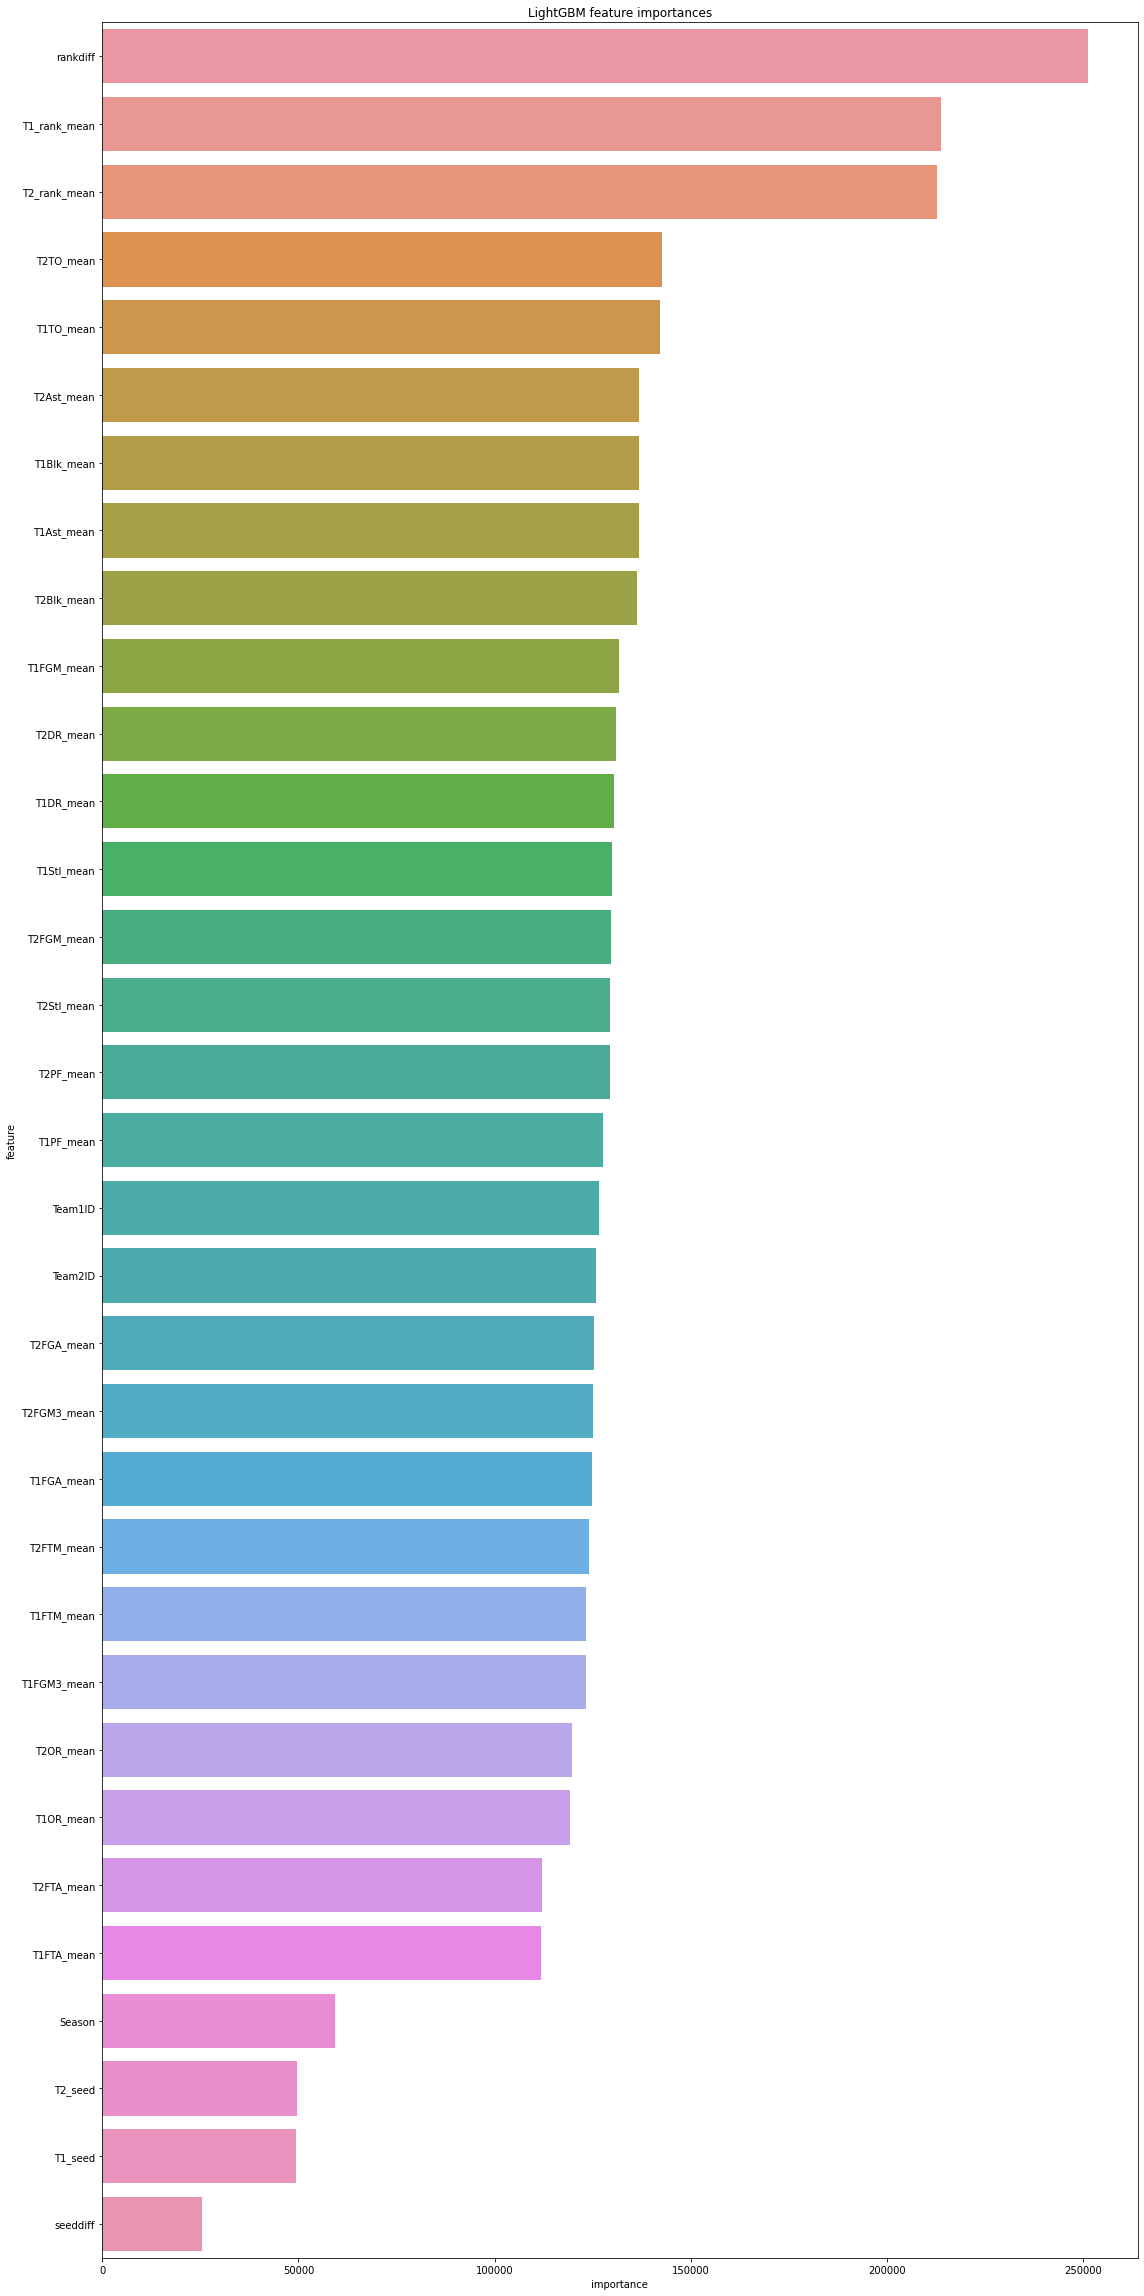

In [25]:
order = list(lgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 32), tight_layout=True)
sns.barplot(x="importance", y="feature", data=lgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("LightGBM feature importances")

**霊夢:rankが結構使われているみたいだね。  
魔理沙:そうだね逆にseedはあんまりかな。**

**Reimu: It seems that rank is used quite a bit.  
Marisa: That's right, on the contrary, seed is not so much.**

<img src="https://1.bp.blogspot.com/-N08ojzWTStM/VdLrmt8nTzI/AAAAAAAAwuU/1o3JOcdtHNM/s400/business_senryaku_sakuryaku_man.png" width=200>

# Inference

**魔理沙:最後にsubmissionファイルを作ろう！<br>
霊夢:最後まで頑張るぞ！**

**Marisa: Finally, let's create a submission file! <br>
Reimu: I'll do my best until the end!**

<img src = "https://4.bp.blogspot.com/-mg-ul7z64Oc/WzC-BvpjsgI/AAAAAAABM94/-OPzexySWfUXUdf6qzZ45CfERCUyoNpBQCLcBGAs/s400/yaruki_moeru_woman.png" width=200>

In [27]:
for pred_num in range(len(lgb_pred)):
    if lgb_pred[pred_num]<0:
        lgb_pred[pred_num]=0
    if lgb_pred[pred_num]>1:
        lgb_pred[pred_num]=1
        
df_submission = pd.read_csv(DATA_PATH + "MSampleSubmissionStage1.csv")
df_submission['Pred'] = lgb_pred
df_submission.to_csv("./output/#11_submission.csv",index = None)
df_submission.head()

,ID,Pred
0,2016_1112_1114,0.672512
1,2016_1112_1122,0.981909
2,2016_1112_1124,0.469880
3,2016_1112_1138,0.936637
4,2016_1112_1139,0.614427


**霊夢:どんな特徴量を作ったら精度が上がるのかな？  
魔理沙:それはたくさんの人のcodeを見て学ばないとね。
霊夢:もっと頑張らなくちゃだね。**

**Reimu: What kind of features should I make to improve the accuracy?  
Marisa: It has to be learned by looking at the codes of many people.  
Reimu: I have to work harder.**

**霊夢&魔理沙:ご覧いただきありがとうございました！良ければUpvoteをよろしくお願いします！**<br>
**Reimu & Marisa: Thank you for visiting! If you like, thank you for Upvote!**

![](https://1.bp.blogspot.com/-PNcKwFw1PpM/U1T3oDIr9CI/AAAAAAAAfT4/gEn86X8Ppx0/s400/figure_goodjob.png)

In [29]:
import pickle
filename = "./output/lgb_models.pickle"
with open(filename, 'bw') as f:
    pickle.dump(models,f)
filename = "./output/lgb_testdata.pickle"
with open(filename,'bw') as f:
    pickle.dump(test,f)